# Prediction of Foraging States of *P. pacificus*

This notebook will guide you through the prediction pipeline for foraging behaviours in *Pristionchus pacificus*.<br>
You will already need to have data that was extracted by PharaGlow.<br>

The single steps of this pipeline are the following:
1. additional feature calculation
2. model and augmentation loading
3. data augmentation as defined by AugmentSelect file
4. prediction
5. visualisation

In [1]:
import os
import time
import tqdm
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, FancyArrowPatch
import logging
import yaml
import json
import joblib
from sklearn.impute import SimpleImputer
from scipy.stats.contingency import crosstab
import networkx as nx
from matplotlib.lines import Line2D
import umap

#home = os.path.expanduser("~")
sys.path.append(os.getcwd())
from functions.load_model import load_tolist
import functions.visualise as vis
import functions.process as proc
from functions.io import setup_logger, makedir
from functions import FeatureEngine
from numba import jit



/gpfs/soma_fs/home/boeger/usr/miniconda3/envs/sklearn-env/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/gpfs/soma_fs/home/boeger/usr/miniconda3/envs/sklearn-env/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/gpfs/soma_fs/home/boeger/

Please provide where your files are stored and where you would like your data to be saved in the following section.

In [2]:
datestr = time.strftime("%Y%m%d-%HH%MM")
home = os.path.expanduser("~")
inpath = f"/gpfs/soma_fs/scratch/src/boeger/data_gueniz/nhr40_OP50"
outpath = makedir(os.path.abspath(f"./data_gueniz/nhr40_OP50")) # you can also use datestr to specify the outpath folder, like this makedir(os.path.abspath(f"{datestr}_PpaPrediction"))
#inpath = os.path.abspath(f"./testset/larvae_data")
#outpath = makedir(os.path.abspath(f"./testout/"))
out_engine = os.path.join(outpath, os.path.basename(inpath)+'_engine')
out_predicted = os.path.join(outpath, os.path.basename(inpath)+'_predicted')

In the following section, standard model parameters are set. Change those only if necessary.

In [3]:
config = yaml.safe_load(open("config.yml", "r"))

In [4]:
cluster_color = config['cluster_color']
cluster_group = config['cluster_group_man']
cluster_label = config['cluster_names']
clu_group_label = {_:f'{_}, {__}' for _, __ in tuple(zip([c for c in cluster_label.values()],[g for g in cluster_group.values()]))}
skip_already = config['settings']['skip_already']

In [5]:
model_path = config['settings']['model']
version = os.path.basename(model_path).split("_")[1].split(".")[0]
ASpath = config['settings']['ASpath']
smooth = config['settings']['fbfill']
fps = config['settings']['fps']
engine_done = []
prediction_done = []

logger_out = os.path.join(outpath,f"{datestr}_PpaForagingPrediction.log")
logger = setup_logger('logger',filename=logger_out)
logger.info(f"Foraging prediction of Pristionchus pacificus")
logger.info(f"Version of model == {version}, stored at {model_path}")
logger.info(f"Files to be predicted stored at {inpath}")

INFO:logger:Foraging prediction of Pristionchus pacificus
INFO:logger:Version of model == 1-1, stored at /gpfs/soma_fs/scratch/src/boeger/model/ForagingPredictionModel_1-1.pickle
INFO:logger:Files to be predicted stored at /gpfs/soma_fs/scratch/src/boeger/data_gueniz/nhr40_OP50


## 1. Feature Engineering
In the following section, additional features are calculated.<br>
The engineerd data files are saved under the specified outpath/subfolder.<br>
(with subfolder being the inpath folder name postfixed by _engine)

In [6]:
XYs, CLines  = FeatureEngine.run(inpath, out_engine, logger, return_XYCLine =True)

/gpfs/soma_fs/scratch/src/boeger/data_gueniz/nhr40_OP50 /gpfs/soma_fs/home/boeger/PpaPred/data_gueniz/nhr40_OP50/nhr40_OP50_engine
{'GGE0152_c_results_106.json_labeldata.csv': '/gpfs/soma_fs/scratch/src/boeger/data_gueniz/nhr40_OP50/GGE0152_c_results_106.json_labeldata.csv', 'GGE0152_c_results_306.json_labeldata.csv': '/gpfs/soma_fs/scratch/src/boeger/data_gueniz/nhr40_OP50/GGE0152_c_results_306.json_labeldata.csv', 'GGE0153_c_results_99.json_labeldata.csv': '/gpfs/soma_fs/scratch/src/boeger/data_gueniz/nhr40_OP50/GGE0153_c_results_99.json_labeldata.csv', 'GGE0152_c_results_121.json_labeldata.csv': '/gpfs/soma_fs/scratch/src/boeger/data_gueniz/nhr40_OP50/GGE0152_c_results_121.json_labeldata.csv', 'GGE0153_c_results_1.json_labeldata.csv': '/gpfs/soma_fs/scratch/src/boeger/data_gueniz/nhr40_OP50/GGE0153_c_results_1.json_labeldata.csv', 'GGE0152_c_results_355.json_labeldata.csv': '/gpfs/soma_fs/scratch/src/boeger/data_gueniz/nhr40_OP50/GGE0152_c_results_355.json_labeldata.csv', 'GGE0153_c

  0%|          | 0/90 [00:00<?, ?it/s]

INFO:logger:
feature calculation for GGE0152_c_results_106.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([197, 199, 200, 202, 204, 205, 206, 207, 213, 214, 222, 223, 224]),)


  1%|          | 1/90 [00:03<04:46,  3.22s/it]

INFO:logger:
feature calculation for GGE0152_c_results_306.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([  23,   25,   28,   29,   30,   31,   32,   33,   34,   35,   36,
         39,   40,   41,   42,   43,   44,   45,   46,   47,   48,   49,
         50,   55,   56,   57,   58,   59,   60,   61,   62,   63,   64,
         65,   66,   67,   68,   69,   96,   97,  103,  104,  105,  106,
        107,  108,  109,  110,  111,  112,  113,  114,  115,  116,  117,
        118,  119,  120,  122,  123,  124,  125,  126,  127,  128,  129,
        130,  145,  153,  154,  158,  159,  160,  161,  162,  163,  164,
        165,  166,  167,  168,  169,  170,  171,  172,  173,  174,  175,
        176,  177,  178,  179,  180,  181,  182,  183,  184,  185,  192,
        193,  194,  195,  196,  197,  198,  199,  200,  201,  202,  203,
        204,  205,  206,  207,  208,  209,  210,  211,  212,  213,  214,
        215,  216,  217,  218,  219, 

/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
  2%|▏         | 2/90 [00:04<03:21,  2.29s/it]

INFO:logger:
feature calculation for GGE0153_c_results_99.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([   1,    6,    8, ..., 3492, 3493, 3494]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
  3%|▎         | 3/90 [00:07<03:38,  2.51s/it]

INFO:logger:
feature calculation for GGE0152_c_results_121.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([4818, 4819, 4820, 4821, 4822, 4823, 4824, 4825, 4826, 4827, 4828,
       4829]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
  4%|▍         | 4/90 [00:11<04:26,  3.10s/it]

INFO:logger:
feature calculation for GGE0153_c_results_1.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([7820, 7821, 7822, 7823]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
  6%|▌         | 5/90 [00:20<07:34,  5.35s/it]

INFO:logger:
feature calculation for GGE0152_c_results_355.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([   3,   18,   25,   47,   68,   75,   76,   77,   78,   80,   81,
         82,   83,   84,   85,   86,   87,   88,   89,   90,   91,   92,
         93,   94,   95,   96,   97,   98,  101,  116,  117,  118,  121,
        122,  123,  124,  125,  126,  127,  128,  129,  130,  131,  135,
        136,  138,  140,  141,  142,  143,  144,  145,  147,  149,  152,
        154,  155,  158,  159,  160,  163,  166,  167,  179,  180,  181,
        182,  185,  186,  187,  193,  201,  202,  203,  207,  209,  214,
        215,  216,  217,  218,  220,  223,  224,  225,  226,  227,  228,
        232,  233,  234,  235,  236,  237,  238,  239,  240,  241,  244,
        245,  246,  248,  250,  251,  252,  253,  255,  258,  259,  260,
        261,  262,  263,  264,  265,  274,  276,  281,  289,  291,  292,
        294,  299,  301,  303,  305, 

/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
/gpfs/soma_fs/home/boeger/PpaPred/functions/FeatureEngine.py:73: RuntimeWarning: invalid value encountered in arccos
  angdiff_nose_frames = np.arccos(nose_unit_frames[1:,0]*nose_unit_frames[:-1,0] +
  7%|▋         | 6/90 [00:22<05:46,  4.13s/it]

INFO:logger:
feature calculation for GGE0153_c_results_21.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([ 986,  987, 2551, 2552, 2553, 2554, 2556, 2557, 2558, 2559, 2787,
       2788, 2789, 2790, 2791, 2792]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
  8%|▊         | 7/90 [00:25<05:08,  3.71s/it]

INFO:logger:
feature calculation for GGE0152_c_results_347.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281,
       1282, 1283, 1284, 1285, 1286, 2622, 2623, 2624, 3622, 3624, 3626,
       3627, 3628]),)


  9%|▉         | 8/90 [00:28<04:43,  3.46s/it]

INFO:logger:
feature calculation for GGE0153_c_results_209.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 10%|█         | 9/90 [00:32<04:55,  3.64s/it]

INFO:logger:
feature calculation for GGE0152_c_results_348.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1994, 1996, 1998, 2000, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026,
       2027, 2028, 2029, 2030, 2031, 2033, 2034, 2035, 2036, 2037, 2038,
       2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2048, 2049, 2050,
       2051, 2053, 2056, 2058, 2059, 2060, 2063, 2065, 2066, 2067, 2068,
       2070, 2073, 2074, 2079, 2083, 2084, 2086, 2087, 2088, 2090, 2092,
       2093, 2095, 2098, 2099, 2101, 2103, 2105, 2152, 2153, 2154, 2158,
       2161, 2162, 2163, 2164, 2165, 2171, 2210, 2214, 2215, 2216, 2217,
       2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228,
       2229, 2230, 2231, 2232, 2233, 

/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 11%|█         | 10/90 [00:34<04:11,  3.14s/it]

INFO:logger:
feature calculation for GGE0153_c_results_5.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([5516, 5517]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 12%|█▏        | 11/90 [00:39<04:50,  3.68s/it]

INFO:logger:
feature calculation for GGE0152_c_results_155.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([  11, 5815, 5816]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
/gpfs/soma_fs/home/boeger/PpaPred/functions/FeatureEngine.py:73: RuntimeWarning: invalid value encountered in arccos
  angdiff_nose_frames = np.arccos(nose_unit_frames[1:,0]*nose_unit_frames[:-1,0] +
 13%|█▎        | 12/90 [00:46<05:56,  4.57s/it]

INFO:logger:
feature calculation for GGE0152_c_results_345.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([ 954,  955,  956, ..., 5116, 5117, 5118]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 14%|█▍        | 13/90 [00:50<05:39,  4.41s/it]

INFO:logger:
feature calculation for GGE0152_c_results_373.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([  82,   83,  559, ..., 4025, 4026, 4027]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 16%|█▌        | 14/90 [00:53<05:07,  4.05s/it]

INFO:logger:
feature calculation for GGE0152_c_results_287.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([2888, 2917, 2918, 2933, 2936, 2937, 2938, 2939, 2940, 2941, 2942,
       2943]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 17%|█▋        | 15/90 [00:55<04:25,  3.53s/it]

INFO:logger:
feature calculation for GGE0153_c_results_207.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([676, 677, 678]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 18%|█▊        | 16/90 [00:58<04:04,  3.30s/it]

INFO:logger:
feature calculation for GGE0153_c_results_184.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([2705]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 19%|█▉        | 17/90 [01:03<04:32,  3.73s/it]

INFO:logger:
feature calculation for GGE0152_c_results_18.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([ 4106, 10034, 16883, 16884, 16885, 16886, 17781, 17782, 17783,
       17784, 17785, 17786, 17788, 17789, 17790, 17791, 17792, 17793,
       17794, 17795, 17796, 17797, 17798, 17799, 17801, 17802, 17803,
       17804, 17805, 17806, 17807, 17808, 17809, 17810, 17811, 17812,
       17813, 17814, 17815, 17817, 17818, 17819, 17820, 17821, 17822,
       17823, 17824, 17825, 17826, 17827, 17828, 17829, 17830, 17831,
       17832, 17833, 17834, 17835, 17836, 17837, 17838, 17839, 17840,
       17841, 17842, 17843, 17844, 17845, 17846, 17847, 17848, 17849,
       17850, 17851, 17852, 17853, 17854, 17855, 17856, 17857, 17858,
       17859, 17860, 17861, 17862, 17863, 17864, 17865, 17866, 17867,
       17868, 17869, 17870, 17871, 17872, 17873, 17874, 17875, 17876,
       17877, 17878, 17879, 17880, 17881, 17882, 17883, 17884, 17885,
 

/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 20%|██        | 18/90 [01:17<08:20,  6.95s/it]

INFO:logger:
feature calculation for GGE0152_c_results_245.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([ 11,  13,  27,  28,  29,  30,  51,  86,  89,  92,  94,  97,  98,
       100, 101, 103, 104, 106, 109, 110, 111, 115, 116, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 195, 199, 204, 205, 207, 208, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226,
       227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 242, 243, 245, 247, 254, 256, 257, 258, 259, 260, 261, 262,
       263, 264, 265, 266, 267, 268, 269, 270, 2

/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 21%|██        | 19/90 [01:26<09:03,  7.66s/it]

INFO:logger:
feature calculation for GGE0153_c_results_34.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 22%|██▏       | 20/90 [01:33<08:39,  7.43s/it]

INFO:logger:
feature calculation for GGE0153_c_results_11.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([1]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
/gpfs/soma_fs/home/boeger/PpaPred/functions/FeatureEngine.py:73: RuntimeWarning: invalid value encountered in arccos
  angdiff_nose_frames = np.arccos(nose_unit_frames[1:,0]*nose_unit_frames[:-1,0] +
 23%|██▎       | 21/90 [01:35<06:42,  5.83s/it]

INFO:logger:
feature calculation for GGE0152_c_results_424.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([ 179,  186,  197, ..., 3059, 3060, 3061]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 24%|██▍       | 22/90 [01:38<05:27,  4.81s/it]

INFO:logger:
feature calculation for GGE0153_c_results_212.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 26%|██▌       | 23/90 [01:41<04:40,  4.19s/it]

INFO:logger:
feature calculation for GGE0153_c_results_47.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([ 531,  533,  535,  536,  537,  538,  539,  540, 1256, 2220]),)


 27%|██▋       | 24/90 [01:42<03:48,  3.47s/it]

INFO:logger:
feature calculation for GGE0152_c_results_321.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 28%|██▊       | 25/90 [01:45<03:28,  3.22s/it]

INFO:logger:
feature calculation for GGE0152_c_results_196.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([   9,   34,   37, ..., 3475, 3476, 3477]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 29%|██▉       | 26/90 [01:48<03:16,  3.07s/it]

INFO:logger:
feature calculation for GGE0153_c_results_64.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 30%|███       | 27/90 [01:50<03:07,  2.98s/it]

INFO:logger:
feature calculation for GGE0152_c_results_314.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([  24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,
         35,   36,   53,   54,   55,   56,   57,   58,   59,   60,   61,
         62,   63,   64,   65,   66,   67,   68,   69,   70,   71,   72,
         73,   74,   75,   76,   77, 2100, 2101, 2102, 2105, 2106, 2107,
       2108, 2168, 2169, 2170, 2172, 2175, 2180, 2184, 2884, 2885, 2886,
       2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897,
       2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908,
       2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919,
       2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930,
       2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941,
       2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952,
       2953, 2954, 2955, 2956, 2957, 

/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 31%|███       | 28/90 [01:54<03:19,  3.22s/it]

INFO:logger:
feature calculation for GGE0153_c_results_33.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 32%|███▏      | 29/90 [01:56<02:52,  2.83s/it]

INFO:logger:
feature calculation for GGE0152_c_results_259.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([   2,    3,    4,    5,    6,    8,    9,   10,   11,   12,   14,
         15,   16,   21,   23,   24,   33,   34,   49,   50,   63, 2832,
       2837, 2838, 2839, 2840, 2846, 2850, 2855, 2856, 2857, 2858, 2859,
       2862, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882,
       3218, 3219, 3223, 3225, 3226, 3229, 3240, 3241, 3242, 3243, 3244,
       3245, 3247, 3248, 3249, 3294, 3295, 3526, 3527]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 33%|███▎      | 30/90 [02:03<04:07,  4.13s/it]

INFO:logger:
feature calculation for GGE0152_c_results_364.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([   1,    2,    3, ..., 2006, 2007, 2009]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 34%|███▍      | 31/90 [02:07<03:56,  4.01s/it]

INFO:logger:
feature calculation for GGE0153_c_results_56.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([482, 483, 484, 485, 486, 487, 488, 489, 491]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 36%|███▌      | 32/90 [02:11<03:48,  3.94s/it]

INFO:logger:
feature calculation for GGE0152_c_results_10.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 37%|███▋      | 33/90 [02:12<03:02,  3.19s/it]

INFO:logger:
feature calculation for GGE0153_c_results_58.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([  47,   48,  314,  315,  316,  317,  318,  319,  320,  321,  322,
       1096, 1097, 1098, 1237, 1242, 1243, 1244, 1245, 1246, 1247, 1248,
       1249, 1250, 1251, 1252, 1253, 1254, 1263, 1264, 1265, 1266, 1267,
       1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1292, 1293,
       1294, 1419, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429,
       1430, 1431, 1432, 1433, 1434, 1435, 1436, 1474, 1476, 1477, 1479,
       1481, 1482, 1485, 1486, 1488, 1489, 1491, 1492, 1497, 1498, 1499,
       1500, 1501, 1502, 1503, 1506, 1507, 1509, 1511, 1512, 1513, 1514,
       1521, 1523, 1524, 1525, 1526, 1532, 1533, 1536, 1537, 1538, 1539,
       1540, 1542, 1543, 1544, 1545, 1546, 1548, 1550, 1551, 1552, 1553,
       1554, 1578, 2167, 2184, 2238, 2239, 2243, 2244, 2245, 2246, 2247,
       2248, 2291, 2292, 2293, 2455, 2

/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 38%|███▊      | 34/90 [02:15<02:42,  2.91s/it]

INFO:logger:
feature calculation for GGE0152_c_results_103.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([   7,    8,    9,  843,  844,  845,  846,  850,  852,  853,  855,
        856,  858,  859,  860, 1009, 1014, 1021, 1022, 1023, 1024, 1025,
       1026, 1027, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037,
       1040, 1042, 1043, 2270, 2278, 2279, 2280, 2281, 2282]),)


 39%|███▉      | 35/90 [02:16<02:21,  2.58s/it]

INFO:logger:
feature calculation for GGE0153_c_results_8.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([ 912,  927,  928, ..., 2690, 2691, 2692]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
/gpfs/soma_fs/home/boeger/PpaPred/functions/FeatureEngine.py:73: RuntimeWarning: invalid value encountered in arccos
  angdiff_nose_frames = np.arccos(nose_unit_frames[1:,0]*nose_unit_frames[:-1,0] +
 40%|████      | 36/90 [02:18<02:11,  2.44s/it]

INFO:logger:
feature calculation for GGE0153_c_results_66.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([ 476,  583,  710,  720,  782, 1532]),)


 41%|████      | 37/90 [02:20<01:55,  2.18s/it]

INFO:logger:
feature calculation for GGE0152_c_results_9.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 42%|████▏     | 38/90 [02:22<01:42,  1.97s/it]

INFO:logger:
feature calculation for GGE0152_c_results_171.json_labeldata.csv


 43%|████▎     | 39/90 [02:24<01:49,  2.15s/it]

INFO:logger:
feature calculation for GGE0152_c_results_284.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([ 275,  276,  277,  278,  279,  280,  281, 1251]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 44%|████▍     | 40/90 [02:33<03:21,  4.04s/it]

INFO:logger:
feature calculation for GGE0153_c_results_229.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([  46,  339,  340, ..., 2330, 2331, 2332]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 46%|████▌     | 41/90 [02:34<02:46,  3.39s/it]

INFO:logger:
feature calculation for GGE0153_c_results_218.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([1049, 1050, 1051, ..., 5041, 5042, 5043]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 47%|████▋     | 42/90 [02:38<02:51,  3.57s/it]

INFO:logger:
feature calculation for GGE0152_c_results_161.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 48%|████▊     | 43/90 [02:41<02:37,  3.36s/it]

INFO:logger:
feature calculation for GGE0153_c_results_2.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
       2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
       2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052,
       2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063,
       2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074,
       2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085,
       2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096,
       2097, 2098, 2099, 2100, 2101, 21

/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 49%|████▉     | 44/90 [02:43<02:18,  3.00s/it]

INFO:logger:
feature calculation for GGE0152_c_results_4.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 50%|█████     | 45/90 [02:45<01:54,  2.55s/it]

INFO:logger:
feature calculation for GGE0152_c_results_349.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 51%|█████     | 46/90 [02:52<02:45,  3.77s/it]

INFO:logger:
feature calculation for GGE0152_c_results_151.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
/gpfs/soma_fs/home/boeger/PpaPred/functions/FeatureEngine.py:73: RuntimeWarning: invalid value encountered in arccos
  angdiff_nose_frames = np.arccos(nose_unit_frames[1:,0]*nose_unit_frames[:-1,0] +
 52%|█████▏    | 47/90 [02:55<02:31,  3.52s/it]

INFO:logger:
feature calculation for GGE0153_c_results_221.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([1075, 1082, 1083]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 53%|█████▎    | 48/90 [02:56<02:06,  3.01s/it]

INFO:logger:
feature calculation for GGE0153_c_results_19.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([  72,   78,   79, ..., 2283, 2284, 2285]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 54%|█████▍    | 49/90 [02:58<01:48,  2.66s/it]

INFO:logger:
feature calculation for GGE0152_c_results_120.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([   8,    9,   10,   15,   16,   19,   20,   22,   30,   31,  782,
        810,  811, 1374, 1576, 1577, 1578, 1579, 1580, 1581, 1586, 1587,
       1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599,
       1600, 1601, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1611, 1618,
       1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638,
       1639, 1640, 1641, 1642, 1643, 1644, 1645, 1655, 1657, 1658, 1662,
       1664, 1669, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682,
       1683, 1684, 1685, 1686, 1687, 1689, 1691, 1694, 1696, 1697, 1722,
       1724, 1725, 1726, 1754, 1755, 1756, 1759, 1760, 1761, 1762, 1763,
       1875, 1876, 1877, 2018, 2024, 2025, 2030, 2031, 2034, 2035, 2036,
       2037, 2038, 2039, 2040, 2043, 2047, 2048, 2052, 2053, 2054, 2186,
       2194, 2197, 2198, 2200, 2201, 

/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 56%|█████▌    | 50/90 [03:00<01:38,  2.47s/it]

INFO:logger:
feature calculation for GGE0152_c_results_118.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([   2,    4,    5,    6,    7,    8,    9,   12,   13,   14,   16,
         17,   18,   19,   20,   21,   22, 2035, 2036, 2037, 2038, 2039,
       2041, 2819, 2820, 2821, 2822]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 57%|█████▋    | 51/90 [03:04<01:55,  2.95s/it]

INFO:logger:
feature calculation for GGE0152_c_results_443.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 58%|█████▊    | 52/90 [03:07<01:45,  2.79s/it]

INFO:logger:
feature calculation for GGE0152_c_results_394.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([42, 43, 44, 45, 46, 47, 48, 49, 51]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 59%|█████▉    | 53/90 [03:11<02:02,  3.30s/it]

INFO:logger:
feature calculation for GGE0153_c_results_65.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 60%|██████    | 54/90 [03:17<02:30,  4.19s/it]

INFO:logger:
feature calculation for GGE0152_c_results_330.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([5278]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 61%|██████    | 55/90 [03:24<02:49,  4.85s/it]

INFO:logger:
feature calculation for GGE0153_c_results_7.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 62%|██████▏   | 56/90 [03:26<02:18,  4.06s/it]

INFO:logger:
feature calculation for GGE0152_c_results_160.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([ 395,  396,  399,  400,  488,  489,  523,  524,  525,  526,  527,
        744,  745,  746,  749,  867,  869,  885,  886,  887,  888,  889,
        890,  891,  914,  915,  916,  923,  946,  947,  948,  949,  950,
        951, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128,
       1129, 1130, 1691, 1695, 1697, 1710, 1711]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 63%|██████▎   | 57/90 [03:28<01:49,  3.31s/it]

INFO:logger:
feature calculation for GGE0153_c_results_59.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
/gpfs/soma_fs/home/boeger/PpaPred/functions/FeatureEngine.py:73: RuntimeWarning: invalid value encountered in arccos
  angdiff_nose_frames = np.arccos(nose_unit_frames[1:,0]*nose_unit_frames[:-1,0] +
 64%|██████▍   | 58/90 [03:31<01:42,  3.20s/it]

INFO:logger:
feature calculation for GGE0153_c_results_213.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 66%|██████▌   | 59/90 [03:33<01:28,  2.84s/it]

INFO:logger:
feature calculation for GGE0152_c_results_357.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([  48,   49,  212, ..., 6368, 6369, 6370]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 67%|██████▋   | 60/90 [03:38<01:44,  3.47s/it]

INFO:logger:
feature calculation for GGE0152_c_results_439.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([3047, 3048]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 68%|██████▊   | 61/90 [03:40<01:32,  3.20s/it]

INFO:logger:
feature calculation for GGE0152_c_results_395.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
/gpfs/soma_fs/home/boeger/PpaPred/functions/FeatureEngine.py:73: RuntimeWarning: invalid value encountered in arccos
  angdiff_nose_frames = np.arccos(nose_unit_frames[1:,0]*nose_unit_frames[:-1,0] +
 69%|██████▉   | 62/90 [03:45<01:40,  3.58s/it]

INFO:logger:
feature calculation for GGE0152_c_results_13.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([2050]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 70%|███████   | 63/90 [03:46<01:21,  3.00s/it]

INFO:logger:
feature calculation for GGE0152_c_results_51.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([2385, 2388, 2390, 2395, 2396, 2402, 2403, 2404, 2405, 2406, 2407,
       2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2419,
       2421, 2422, 2423, 2424, 2425, 2431, 2432, 2433, 2434, 2435, 2436,
       2437, 2438, 2439, 2440, 2441, 2451]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 71%|███████   | 64/90 [03:48<01:12,  2.77s/it]

INFO:logger:
feature calculation for GGE0153_c_results_210.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 72%|███████▏  | 65/90 [03:51<01:08,  2.76s/it]

INFO:logger:
feature calculation for GGE0152_c_results_423.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 73%|███████▎  | 66/90 [03:53<01:02,  2.59s/it]

INFO:logger:
feature calculation for GGE0153_c_results_103.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([ 660,  661,  662, ..., 3225, 3226, 3227]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 74%|███████▍  | 67/90 [03:56<00:59,  2.60s/it]

INFO:logger:
feature calculation for GGE0152_c_results_117.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([    1,    75,    77, ..., 16606, 16607, 16608]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 76%|███████▌  | 68/90 [04:09<02:05,  5.71s/it]

INFO:logger:
feature calculation for GGE0153_c_results_3.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([6108, 6109, 6110, 6114, 6115, 6116, 6119]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 77%|███████▋  | 69/90 [04:14<01:54,  5.47s/it]

INFO:logger:
feature calculation for GGE0153_c_results_6.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([   1,    2,    3, ..., 2673, 2674, 2675]),)


 78%|███████▊  | 70/90 [04:16<01:29,  4.47s/it]

INFO:logger:
feature calculation for GGE0153_c_results_10.json_labeldata.csv


 79%|███████▉  | 71/90 [04:18<01:11,  3.75s/it]

INFO:logger:
feature calculation for GGE0152_c_results_184.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([ 580,  581,  582,  583,  584,  585, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 2657, 2658, 2659, 2660, 2661]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 80%|████████  | 72/90 [04:20<00:59,  3.31s/it]

INFO:logger:
feature calculation for GGE0153_c_results_36.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 81%|████████  | 73/90 [04:22<00:47,  2.77s/it]

INFO:logger:
feature calculation for GGE0153_c_results_18.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([1575]),)


 82%|████████▏ | 74/90 [04:23<00:38,  2.42s/it]

INFO:logger:
feature calculation for GGE0152_c_results_144.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([   5,    7,    8,   17,   18,   19,   27,   28,   41,   42,   43,
         44,   45,   46,   48,   49,   50,   51,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
         67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
         78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,   95,   96,   97,   98,   99,
        100,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,
        111,  112,  113,  114,  115,  116,  117,  118,  119,  120,  121,
        122,  123,  124,  125,  126,  127,  128,  129,  130,  131,  132,
        133,  134,  135,  136,  137,  138,  139,  140,  141,  142,  143,
        144,  145,  146,  147,  148,  149,  150,  151,  152,  153,  154,
        155,  156,  157,  158,  159, 

/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 83%|████████▎ | 75/90 [04:25<00:33,  2.21s/it]

INFO:logger:
feature calculation for GGE0152_c_results_291.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 84%|████████▍ | 76/90 [04:34<00:59,  4.25s/it]

INFO:logger:
feature calculation for GGE0152_c_results_276.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([ 877,  878, 3613, ..., 5743, 5744, 5745]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 86%|████████▌ | 77/90 [04:39<00:57,  4.46s/it]

INFO:logger:
feature calculation for GGE0152_c_results_97.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([   1,    2,    3,    4,    6,    7,    8,   11,   12,   13,   14,
         15,   17,   24,   25,   26,   30,   31,   45,   46,   47,   48,
         49,   50,   51,   53,   54,   55,   56,   60,   61,   68,   69,
         72,   75,   77,   78,   79,   80,   83,   84,   86,   88,   98,
        101,  105,  108,  110,  111,  112,  113,  114,  116,  117,  118,
        119,  120,  121,  122,  123,  124,  125,  127,  128,  129,  130,
        136,  137,  143,  146,  158,  174,  175,  176,  177,  178,  179,
        180,  181,  182,  183,  184,  185,  186,  187,  188,  189,  190,
        191, 2157, 2174, 2651, 2653, 2655, 2669, 2671, 3430, 3431, 3432,
       3433, 3434, 3449, 3450, 3451, 3454, 3480, 3481, 3572, 4764, 4765,
       4766, 4767, 4768, 4808, 4809]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 87%|████████▋ | 78/90 [04:44<00:54,  4.55s/it]

INFO:logger:
feature calculation for GGE0152_c_results_393.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([   2,    4,    5, ..., 1300, 1301, 1302]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 88%|████████▊ | 79/90 [04:49<00:50,  4.62s/it]

INFO:logger:
feature calculation for GGE0152_c_results_172.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 89%|████████▉ | 80/90 [04:51<00:40,  4.01s/it]

INFO:logger:
feature calculation for GGE0152_c_results_317.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([ 405,  406,  407,  408,  620,  621,  622,  623, 3251, 3259, 3260,
       3261, 3262, 3263, 3264, 3265, 3266, 3267, 3275, 3276, 3277, 3278,
       3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289,
       3290, 3294, 3298, 3299, 3300, 3301, 3302, 3303, 3308, 3309, 3310,
       3311, 3314, 3318, 3319, 3320, 3325, 3326, 3327, 3328, 3329, 3330,
       3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341,
       3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352,
       3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363,
       3364, 3365, 3366, 3367, 3368, 3373, 3374, 3375, 3376, 3377, 3378,
       3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3391, 3392,
       3394, 3395, 3401, 3402, 3403, 3407, 3409, 3410, 3500, 3506]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 90%|█████████ | 81/90 [04:54<00:32,  3.65s/it]

INFO:logger:
feature calculation for GGE0153_c_results_100.json_labeldata.csv


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 91%|█████████ | 82/90 [04:57<00:26,  3.30s/it]

INFO:logger:
feature calculation for GGE0152_c_results_286.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([ 137,  138,  139,  140,  141,  142,  143,  144,  150,  151,  201,
        202,  211,  212,  213,  217,  219,  220,  224,  226,  228,  229,
        230,  231,  232,  233,  234,  236,  237,  238,  239,  241,  246,
        248,  250,  253,  256,  258, 1261, 1264, 1265, 1286, 1287, 1364,
       1365, 1366, 1367, 1368, 1369, 1370, 1371, 1580, 1582, 1587, 1588,
       1589, 1590, 1591, 1592, 1593, 1594]),)


 92%|█████████▏| 83/90 [04:58<00:20,  2.87s/it]

INFO:logger:
feature calculation for GGE0152_c_results_8.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([  38,   39,   40,   41,   42,   43,   44,   45,   46,   47,  135,
        136,  137,  138,  498,  499, 1568, 1569, 1570, 1571, 1572, 1573,
       1574, 1575, 1576, 1579, 1798, 1799, 1801]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 93%|█████████▎| 84/90 [05:00<00:14,  2.44s/it]

INFO:logger:
feature calculation for GGE0152_c_results_129.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([   2,    9,   10, ..., 2808, 2809, 2810]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 94%|█████████▍| 85/90 [05:02<00:11,  2.38s/it]

INFO:logger:
feature calculation for GGE0152_c_results_446.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([ 327, 1627, 1631, 1632, 1633, 1634, 1635, 1638, 1639, 1640, 1641,
       1642, 1643, 1644, 1645, 1664, 1665, 1666, 1670, 1671, 1672, 1673,
       1696, 1702, 1704, 1705, 1706, 1707, 1709, 1713, 1716, 1717, 1718,
       1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1729, 1730,
       1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1741, 1742,
       1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1752, 1753, 1754,
       1755, 1756, 1761, 1762, 1763, 1765, 1766, 1767, 1768, 1769, 1770,
       1771, 1775, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785,
       1786, 1787, 1788, 1789, 1791, 1792, 1793, 1823, 1824, 1825, 1826,
       1827, 1828, 1829, 1830, 1831, 1832, 1834, 1835, 1836]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 96%|█████████▌| 86/90 [05:04<00:09,  2.28s/it]

INFO:logger:
feature calculation for GGE0153_c_results_91.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([1855, 1856, 1857, ..., 5293, 5294, 5295]),)


 97%|█████████▋| 87/90 [05:08<00:08,  2.85s/it]

INFO:logger:
feature calculation for GGE0152_c_results_289.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([ 195,  196,  197,  198,  199,  200,  201,  202,  218,  219, 2331,
       2332, 2334, 2335, 2336, 2484, 2489, 2871, 2877, 2878, 2879, 2880,
       2881, 6243, 6244, 6245, 6246, 6247, 6248, 6275, 6276, 6277, 6278,
       6279, 6280, 6281, 6282, 6283, 6284, 6285, 6286, 6288, 6290, 8482]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
 98%|█████████▊| 88/90 [05:17<00:09,  4.60s/it]

INFO:logger:
feature calculation for GGE0152_c_results_11.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448,
       449, 450, 451, 452, 453, 454, 455, 456]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
/gpfs/soma_fs/home/boeger/PpaPred/functions/FeatureEngine.py:73: RuntimeWarning: invalid value encountered in arccos
  angdiff_nose_frames = np.arccos(nose_unit_frames[1:,0]*nose_unit_frames[:-1,0] +
 99%|█████████▉| 89/90 [05:20<00:04,  4.02s/it]

INFO:logger:
feature calculation for GGE0152_c_results_175.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([  62,   63,   64,   65, 1215, 1218, 1220, 1221, 1222, 1223]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)
100%|██████████| 90/90 [05:22<00:00,  3.59s/it]


## 2. Load Model and Augmentation
Here only the model- and augmentation-files are loaded

In [7]:
import pickle
model = joblib.load(open(model_path, 'rb'))
augsel = joblib.load(ASpath)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [8]:
model

Pipeline(memory='/gpfs/soma_fs/scratch/src/boeger',
         steps=[('minmax_scaler', MinMaxScaler()),
                ('UMAP',
                 UMAP(min_dist=0.0, n_components=3, n_neighbors=30, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})),
                ('XGB',
                 XGBClassifier(base_score=None, booster=None, callba...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.004138018761240318, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=31,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=1535, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [9]:
augsel

Pipeline(steps=[('add_history',
                 FunctionTransformer(func=<function addhistory at 0x2b7e88000ee0>,
                                     kw_args={'dt_shifted': [5, 10, 15]})),
                ('select_features',
                 FunctionTransformer(func=<function select_features at 0x2b7e8927e550>,
                                     kw_args={'names': 'all'}))])

## 3. Add History

In [10]:
out_predicted = makedir(out_predicted)
for fn in tqdm.tqdm(os.listdir(out_engine)):
    out_fn = '_'.join(fn.split('_')[:4]+['predicted.json'])
    if skip_already:
        prediction_done = [f for f in os.listdir(out_predicted)]
    if not fn[0] == '.' and not out_fn in prediction_done and os.path.isfile(fn):
        d = load_tolist(os.path.join(out_engine, fn), droplabelcol=False)[0]
        X = augsel.fit_transform(d)
        col = X.columns
        X = imp.fit_transform(X)

        proba = model.predict_proba(X)
        proba_smooth = pd.DataFrame(proba).rolling(30, min_periods=1, center=True).mean().values
        pred = np.argmax(proba_smooth, axis=1)
        pred_smooth = proc.ffill_bfill(pred, smooth)
        pred_smooth = np.nan_to_num(pred_smooth,-1)

        #y_pred.append(pred)
        #y_proba.append(proba)
        #y_pred_smooth.append(pred_smooth)
        #X_augm.append(pd.DataFrame(X, columns=col))

        #fn = os.path.basename(fn)
        #out_fn = '_'.join(fn.split('_')[:4]+['predicted.json'])
        p_out = pd.concat([d, pd.DataFrame(pred_smooth, columns=['prediction'])], axis=1)

        jsnL = json.loads(p_out.to_json(orient="split"))
        jsnF = json.dumps(jsnL, indent = 4)
        outpath_p = os.path.join(out_predicted,out_fn)
        with open(outpath_p, "w") as outfile:
            outfile.write(jsnF)

100%|██████████| 91/91 [00:00<00:00, 11706.23it/s]


In [18]:
fn

'GGE0152_c_results_393_predicted.json'

## 4. Prediction
The augmented + predicted data files are saved under the specified outpath/subfolder.<br>
(with subfolder being the inpath folder name postfixed by _predicted)<br>

In the _predicted, plots of the bouts predicted over time along with the velocity and pumping rate are saved as pdf files.

  0%|          | 0/135 [00:00<?, ?it/s]

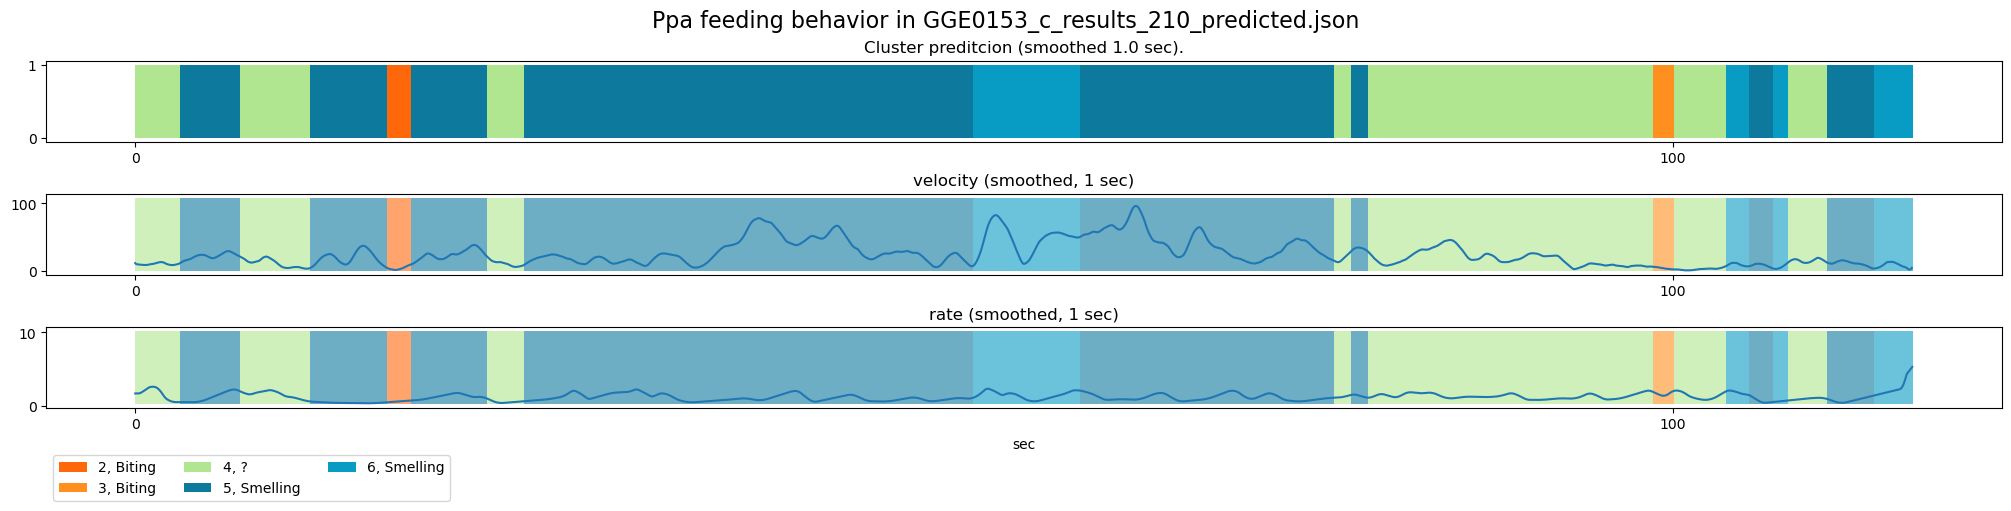

/tmp/jobs/boeger/15433002/ipykernel_79498/3777671667.py:45: RuntimeWarning: invalid value encountered in divide
  transition_toother = fr_transition/othersum_axis0
/tmp/jobs/boeger/15433002/ipykernel_79498/3777671667.py:46: RuntimeWarning: invalid value encountered in divide
  transition_self = fr_transition.diagonal()/(othersum_axis0+fr_transition.diagonal())


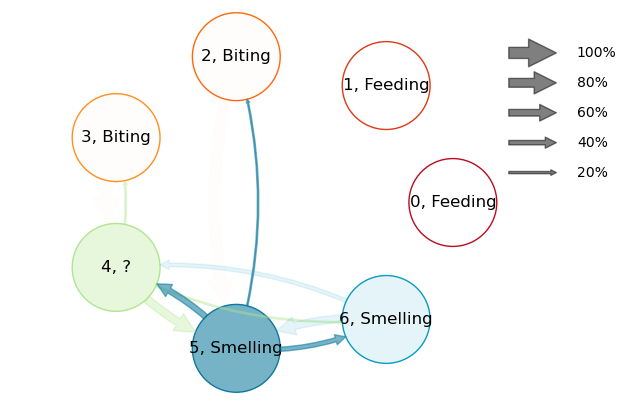

  1%|          | 1/135 [00:05<12:22,  5.54s/it]

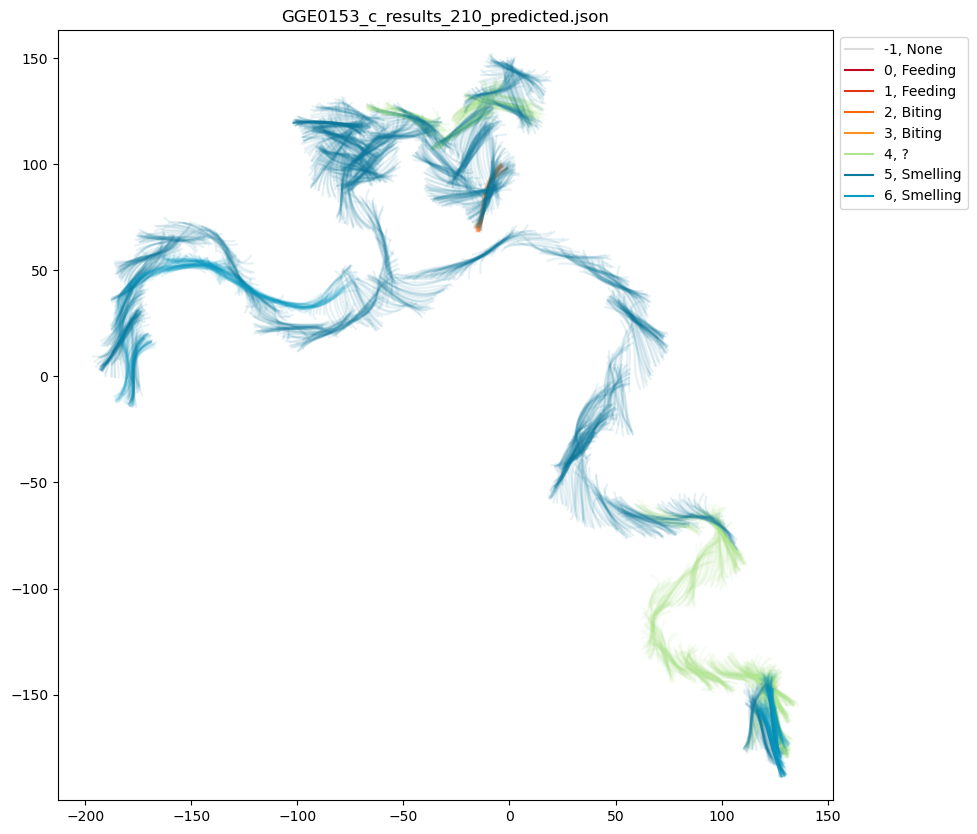

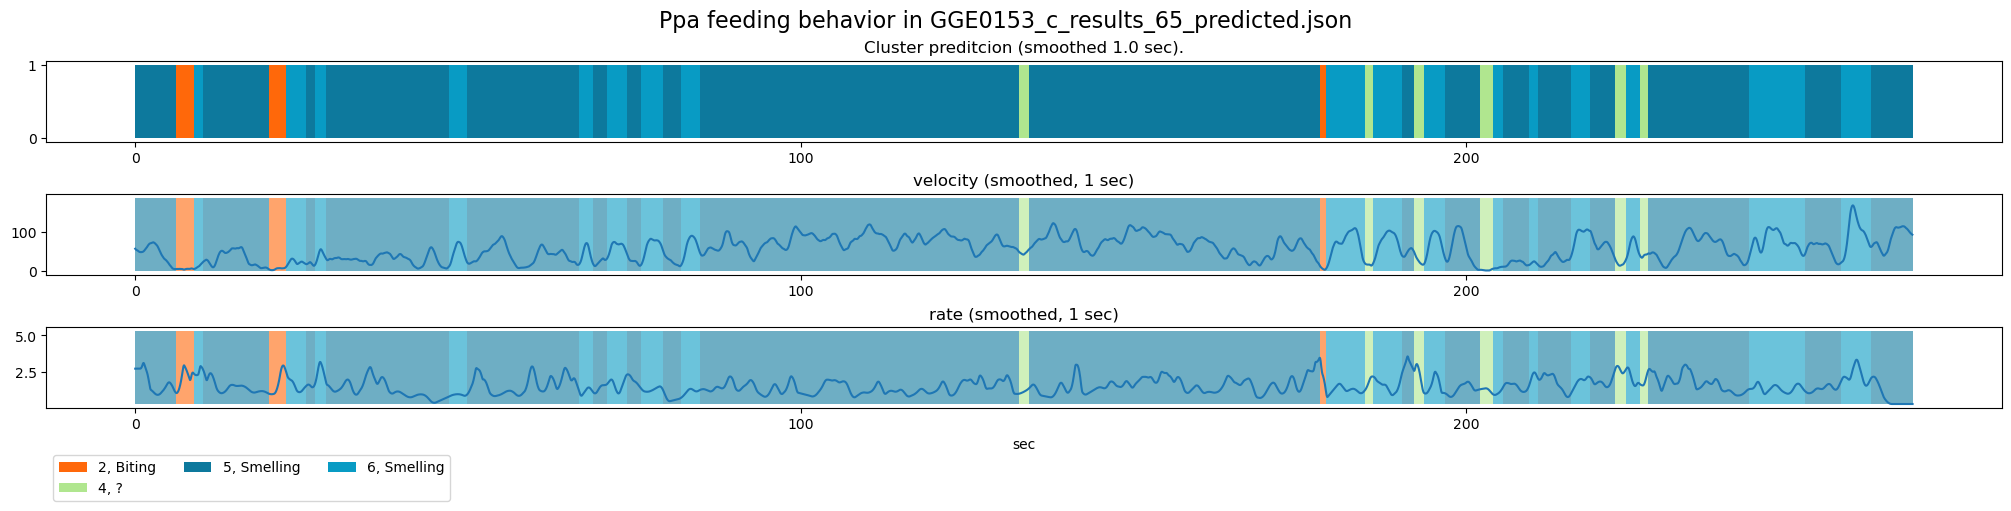

/tmp/jobs/boeger/15433002/ipykernel_79498/3777671667.py:45: RuntimeWarning: invalid value encountered in divide
  transition_toother = fr_transition/othersum_axis0
/tmp/jobs/boeger/15433002/ipykernel_79498/3777671667.py:46: RuntimeWarning: invalid value encountered in divide
  transition_self = fr_transition.diagonal()/(othersum_axis0+fr_transition.diagonal())


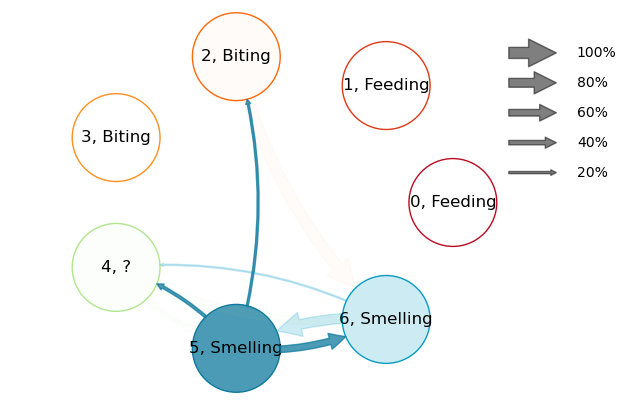

  1%|▏         | 2/135 [00:15<18:16,  8.24s/it]

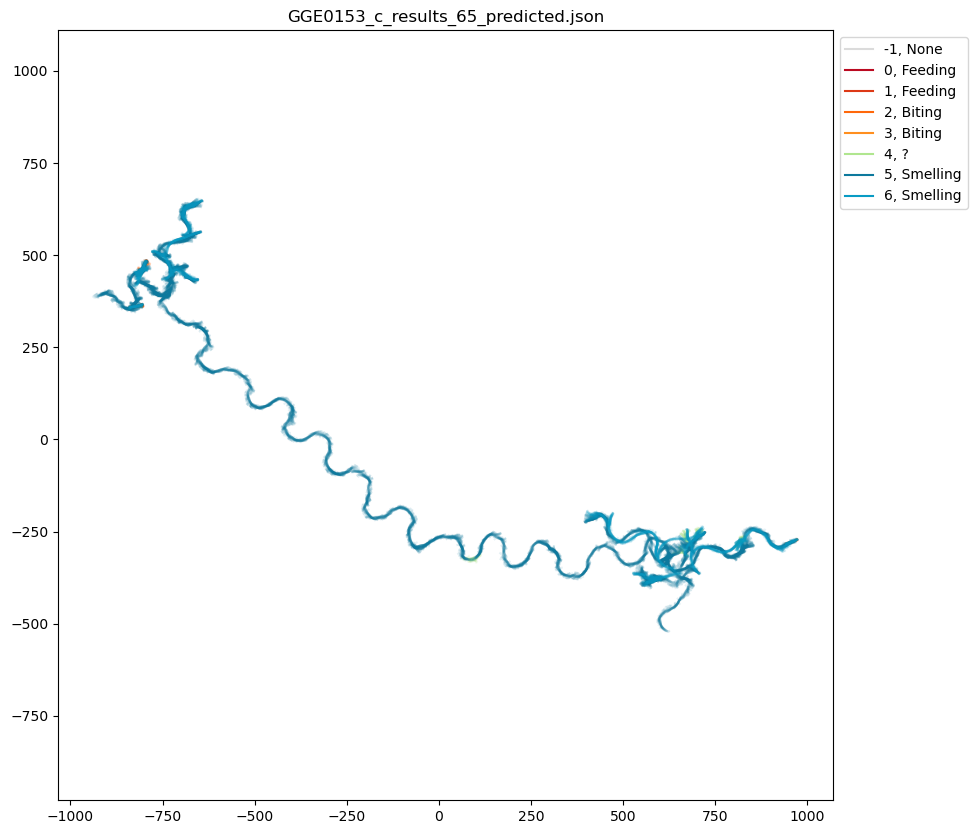

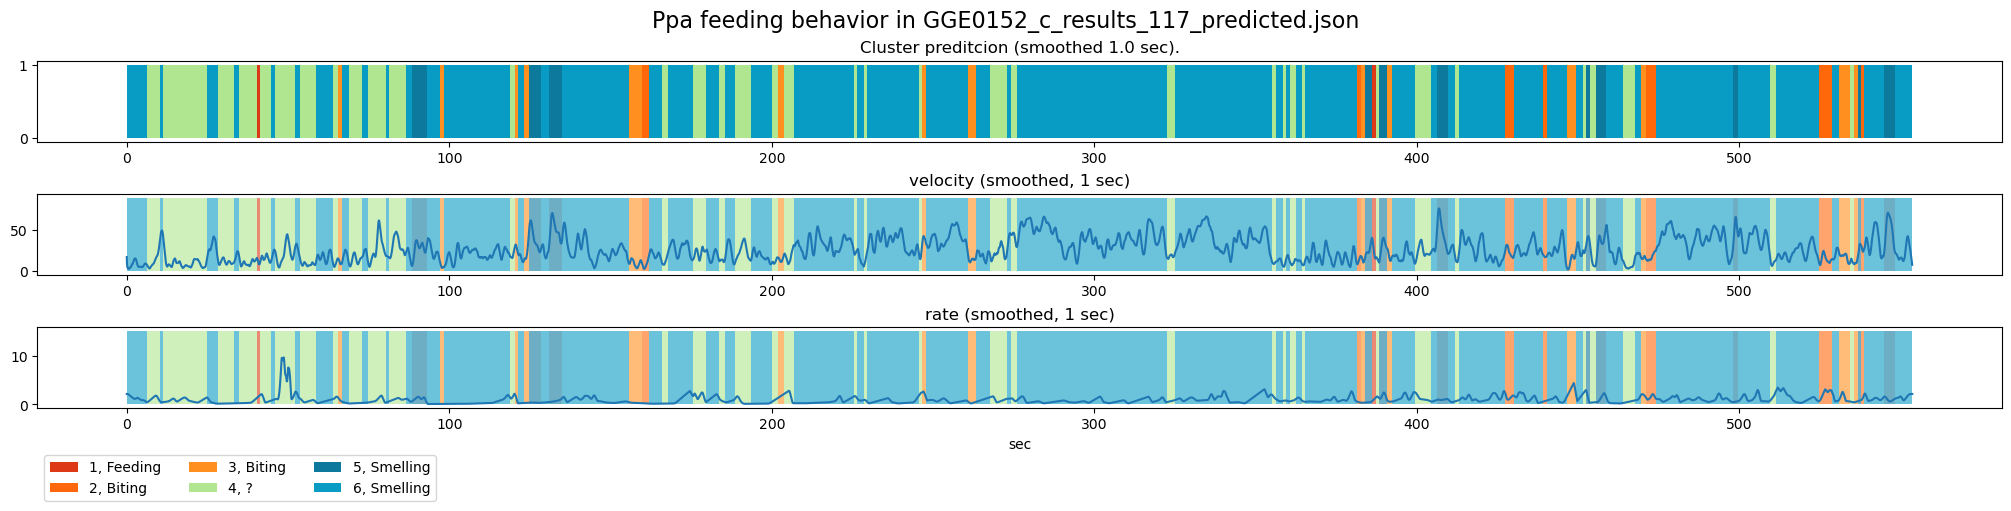

/tmp/jobs/boeger/15433002/ipykernel_79498/3777671667.py:45: RuntimeWarning: invalid value encountered in divide
  transition_toother = fr_transition/othersum_axis0
/tmp/jobs/boeger/15433002/ipykernel_79498/3777671667.py:46: RuntimeWarning: invalid value encountered in divide
  transition_self = fr_transition.diagonal()/(othersum_axis0+fr_transition.diagonal())


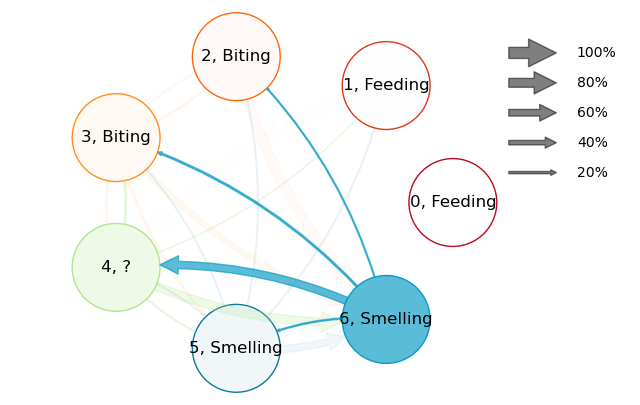

  4%|▎         | 5/135 [00:36<15:57,  7.37s/it]


KeyboardInterrupt: 

In [40]:
for fn in tqdm.tqdm(os.listdir(out_predicted)):
    if fn[-3:] == 'csv' or fn[-4:] == 'json':
        d = load_tolist(os.path.join(out_predicted,fn), droplabelcol=False)[0]
        y_ps = d['prediction'].values
        onoff = proc.onoff_dict(y_ps, labels =np.unique(y_ps))
        timeinsec = np.array(range(len(d)))/30
        fig, axs = plt.subplots(3,1, figsize=(20,5),constrained_layout=True)

        for c in np.unique(y_ps).astype(int):
            axs[0].broken_barh(onoff[c],(0,1),facecolors = cluster_color[c])
        axs[0].set_xticks(range(len(timeinsec))[::100*30])
        axs[0].set_xticklabels(timeinsec[::100*30].astype(int))
        axs[0].set_title(f'Cluster preditcion (smoothed {smooth/fps} sec).')
        for i,c in enumerate(['velocity', 'rate']):
            for c_ in np.unique(y_ps).astype(int):
                axs[i+1].broken_barh(onoff[c_],(min(d[c]),max(d[c])),facecolors = cluster_color[c_], alpha=0.6, zorder=0)
            axs[i+1].plot(d[c].rolling(30, min_periods=0).mean())
            axs[i+1].set_xticks(range(len(timeinsec))[::100*30])
            axs[i+1].set_xticklabels(timeinsec[::100*30].astype(int))
            axs[i+1].set_title(f"{c} (smoothed, 1 sec)")
        axs[2].set_xlabel('sec')

        plt.legend(handles=[Patch(facecolor=cluster_color[i]) for i in np.unique(y_ps).astype(int)],
              labels=[clu_group_label[k] for k in cluster_label if k in np.unique(y_ps)],
              ncol=3, loc='upper left',
              bbox_to_anchor=(0, -0.5))
        fig.suptitle(f'Ppa feeding behavior in {fn}',fontsize=16)
        plt.savefig(os.path.join(out_predicted, '_'.join(fn.split('_')[:4]+['predictedbouts.pdf'])))
        plt.show()

        idx = pd.IndexSlice
        onoff, dur, transi = proc.onoff_dict(y_ps, labels =np.unique(y_ps), return_duration=True, return_transitions=True)
        data_describe = d.groupby(y_ps).describe().T.loc[idx[:, ['mean','std','count']], :].sort_index(level=0).T
        dur_describe = pd.DataFrame(dur, columns=['duration']).groupby(transi).describe().T.loc[idx[:, ['mean','std','count']], :].sort_index(level=0).T
        summary = pd.concat([dur_describe, data_describe], axis=1)
        summary.index.name = 'cluster'
        summary = summary.T.reset_index(drop=True).set_index(summary.T.index.map('_'.join)).T
        summary = summary.set_index(summary.index.astype(int))
        summary.to_csv(os.path.join(out_predicted, '_'.join(fn.split('_')[:4]+['summary.csv'])), index=False)

        frame = y_ps

        trans_col,fr_transition = crosstab(frame[1:], frame[:-1], levels=([k for k in cluster_label if k != -1],[k for k in cluster_label if k != -1]))
        othersum_axis0 = fr_transition.sum(axis=0)-fr_transition.diagonal()
        transition_toother = fr_transition/othersum_axis0
        transition_self = fr_transition.diagonal()/(othersum_axis0+fr_transition.diagonal())
        np.fill_diagonal(transition_toother, 0)

        transition_all = transition_toother.copy()
        diag_idx = np.diag_indices(len(transition_toother))
        transition_all[diag_idx] = transition_self
        transition_all = pd.DataFrame(transition_all, columns = trans_col[1], index=trans_col[0])
        transition_all.to_csv(os.path.join(out_predicted, '_'.join(fn.split('_')[:4]+['transitions.csv'])), index=False)

        A = np.around(transition_toother,2).T
        labels = dict(zip(range(len(trans_col[0])),trans_col[0]))
        G = nx.from_numpy_matrix(transition_toother.T, create_using=nx.DiGraph)

        # Set node labels to A, B, C, D, E
        #nx.set_node_attributes(G, {k: {'label': clu_group_label[k]} for k in clu_group_label.keys()})
        #nx.set_edge_attributes(G, {(e[0], e[1]): {'label': e[2]['weight']} for e in G.edges(data=True)})
        weights = nx.get_edge_attributes(G,'weight').values()
        arr_out = [e[0] for e in G.edges(data=True)]

        fig, ax = plt.subplots(1, figsize=(8,5))

        fig_w = fig.get_size_inches()[0]
        arrowsize = [w*fig_w*5 for w in weights]
        labels = dict(zip(range(len(G)),  [clu_group_label[k] for k in cluster_label if k != -1]))
        label_collection = nx.draw_networkx_labels(G, pos=nx.circular_layout(G), ax=ax, labels=labels)
        cluster_alpha = ((summary['duration_mean']*summary['duration_count'])/len(y_ps)).reindex([k for k in cluster_label if k != -1]).fillna(0)
        color_map = [cluster_color[k] for k in cluster_color if k != -1]
        edge_color = [cluster_color[c] for c in arr_out]
        edge_alpha = [cluster_alpha[c] for c in arr_out]
        node_collection = nx.draw_networkx_nodes(G, pos=nx.circular_layout(G), ax=ax, node_color = color_map, node_size= 4000, margins=0.1,
                                                 alpha= cluster_alpha,
                                                 edgecolors=color_map)
        edge_collection = nx.draw_networkx_edges(G, pos=nx.circular_layout(G), ax=ax, 
                                                 arrowsize =arrowsize, connectionstyle="arc3,rad=0.15", arrowstyle="simple",
                                                 alpha=edge_alpha, label=list(weights), node_size=4000, edge_color=edge_color)
        for ed in edge_collection:
            ed.set_zorder(20)
        #edge_label_col =  nx. draw_networkx_edge_labels(G, pos=nx.circular_layout(G), ax=ax, edge_labels= {(e[0], e[1]):e[2]['weight'] for e in G.edges(data=True)}, label_pos=0.4)

        #fig, ax = plt.subplots(1, figsize=(7,5))
        for arr_s in np.linspace(0.2,1,5):
            arrow = FancyArrowPatch((1.3, arr_s), (1.6, arr_s), mutation_scale=arr_s*fig_w*5, label = arr_s, color='k', alpha=0.5)
            ax.text(1.7, arr_s-0.03, f"{int(arr_s*100)}%")
            ax.add_patch(arrow)
        ax.set_xlim(-1.5,2)
        ax.axis('off')
        plt.savefig(os.path.join(out_predicted, '_'.join(fn.split('_')[:4]+['transitions.pdf'])))
        plt.show()

        XY = XYs['_'.join(fn.split('_')[:4])+'.json_labeldata.csv']
        CLine = CLines['_'.join(fn.split('_')[:4])+'.json_labeldata.csv']

        fig, ax = plt.subplots(figsize=(10,10))
        legend_elements = [Line2D([0], [0],color=cluster_color[i], label=clu_group_label [i]) for i in cluster_label]
        adjustCL = (CLine-np.mean(CLine))+np.repeat(XY.reshape(XY.shape[0],1,XY.shape[1]), CLine.shape[1], axis=1)-np.mean(XY, axis=0)# fits better than subtracting 50
        adjustXY = XY-np.mean(XY, axis=0)
        for l in np.unique(y_ps).astype(int):
        #for l in [2,3,5,8]:#[1,2,6,7]#[2,3,5,8]
            #if l != 6:
            il = np.where(y_ps == l)[0]
            ax.plot(*adjustCL[il].T, c=cluster_color[l], alpha = 0.1)#cluster_color[l]
                #plt.scatter(XY[:,0][il],XY[:,1][il], marker=".", lw=2, c=bar_c[l], alpha=0.1)
        ax.set_title(fn)
        ax.axis('equal')
        ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1,1))
        plt.savefig(os.path.join(out_predicted, '_'.join(fn.split('_')[:4]+['CLtrajectory.pdf'])))

In [13]:
loc = {}
for fn in os.listdir(out_predicted):
    if "predicted.json" in fn:
        loc[fn]= os.path.join(out_predicted, fn)

data_batch = load_tolist(loc, droplabelcol=False)
data_batch_concat = pd.concat([d for d in data_batch], axis=0)

GGE0153_c_results_210_predicted.json
GGE0153_c_results_65_predicted.json
GGE0152_c_results_117_predicted.json
GGE0153_c_results_1_predicted.json
GGE0152_c_results_172_predicted.json
GGE0153_c_results_21_predicted.json
GGE0153_c_results_59_predicted.json
GGE0153_c_results_8_predicted.json
GGE0153_c_results_47_predicted.json
GGE0152_c_results_394_predicted.json
GGE0152_c_results_196_predicted.json
GGE0152_c_results_175_predicted.json
GGE0152_c_results_259_predicted.json
GGE0152_c_results_443_predicted.json
GGE0152_c_results_289_predicted.json
GGE0152_c_results_118_predicted.json
GGE0152_c_results_321_predicted.json
GGE0152_c_results_121_predicted.json
GGE0152_c_results_317_predicted.json
GGE0152_c_results_357_predicted.json
GGE0152_c_results_287_predicted.json
GGE0152_c_results_347_predicted.json
GGE0152_c_results_355_predicted.json
GGE0153_c_results_58_predicted.json
GGE0152_c_results_349_predicted.json
GGE0153_c_results_221_predicted.json
GGE0152_c_results_13_predicted.json
GGE0153_c_r

In [21]:
out_predicted

'/gpfs/soma_fs/home/boeger/PpaPred/data_gueniz/nhr40_OP50/nhr40_OP50_predicted'

In [14]:
y_ps = data_batch_concat['prediction']
y_batch = [d['prediction'] for d in data_batch]
fn = out_predicted+'_batch'

In [18]:
def onoff_dict(arr_raw, labels = range(-1,4), return_duration=False, return_transitions = False, return_all = False, treatasone=True):

    if not isinstance(arr_raw, list):
        arr_raw = [arr_raw]

    arr_onoff = {}
    arr_transi =  []
    arr_onset =  []
    arr_onnext =  []
    arr_dur =  []
    total_dur = 0
    for i,a in enumerate(arr_raw):
        if isinstance(a, pd.Series) or isinstance(a, pd.DataFrame):
            a = a.values
        arr_s = a[1:]
        arr = a[:-1]

        transi = np.append(arr[arr != arr_s], arr[-1])
        onset = (np.concatenate([[0],np.where([arr != arr_s])[1]+1]))
        onnext = (np.append(np.array((onset)[1:]), [len(arr)+1]))
        dur = (onnext)-onset
        arr_transi.append(transi)
        arr_onset.append(onset)
        arr_onnext.append(onnext)
        arr_dur.append(dur)

        if treatasone:
            if i > 0:
                total_dur += arr_onnext[i-1][-1]

        for b in np.unique(a):
            b_idx = np.where(transi == b)
            b_onoff = list(zip(onset[b_idx]+total_dur, dur[b_idx]+total_dur))
            if b in arr_onoff.keys():
                arr_onoff[b] = arr_onoff[b]+b_onoff
            else:
                arr_onoff[b] = b_onoff
    if treatasone:
        arr_dur = np.concatenate(arr_dur)
        arr_transi = np.concatenate(arr_transi)
        arr_onset = np.concatenate([a+arr_onnext[i-1][-1] if i > 0 else a for i,a in enumerate(arr_onset)])
        arr_onnext = np.concatenate([a+arr_onnext[i-1][-1] if i > 0 else a for i,a in enumerate(arr_onnext)])
        # might hav to work here on further, change how arr_onset and arr_onnext are daved

    if return_all == True:
        return arr_onoff, arr_dur, arr_transi, arr_onset, arr_onnext
    elif return_transitions == True and return_duration == True:
        return arr_onoff, arr_dur, arr_transi
    elif return_duration == True or return_transitions == True:
        if return_duration == True:
            return arr_onoff, arr_dur
        if return_transitions == True:
            return arr_onoff, arr_transi
    else:
        return arr_onoff

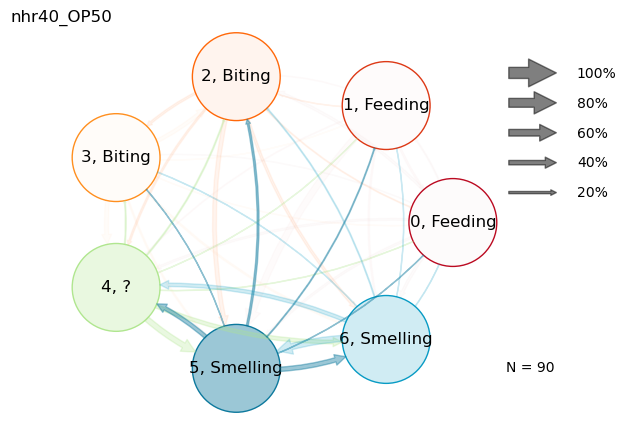

In [39]:
idx = pd.IndexSlice
onoff, dur, transi = onoff_dict(y_batch, labels =np.unique(y_ps), return_duration=True, return_transitions=True)
data_describe = data_batch_concat.groupby(y_ps).describe().T.loc[idx[:, ['mean','std','count']], :].sort_index(level=0).T
dur_describe = pd.DataFrame(dur, columns=['duration']).groupby(transi).describe().T.loc[idx[:, ['mean','std','count']], :].sort_index(level=0).T
summary = pd.concat([dur_describe, data_describe], axis=1)
summary.index.name = 'cluster'
summary = summary.T.reset_index(drop=True).set_index(summary.T.index.map('_'.join)).T
summary = summary.set_index(summary.index.astype(int))
summary.to_csv(os.path.join(out_predicted, os.path.basename(outpath)+'_batch_summary.csv'), index=False)


for i,d in enumerate(data_batch):
    frame = d['prediction']
    trans_col_,fr_transition_ = crosstab(frame[1:], frame[:-1], levels=([k for k in cluster_label if k != -1],[k for k in cluster_label if k != -1]))
    if i == 0:
        fr_transition = fr_transition_
        trans_col = trans_col_
    if trans_col_ == trans_col:
        fr_transition += fr_transition_
    else:
        print('WARNING')
    
othersum_axis0 = fr_transition.sum(axis=0)-fr_transition.diagonal()
transition_toother = fr_transition/othersum_axis0
transition_self = fr_transition.diagonal()/(othersum_axis0+fr_transition.diagonal())
np.fill_diagonal(transition_toother, 0)

transition_all = transition_toother.copy()
diag_idx = np.diag_indices(len(transition_toother))
transition_all[diag_idx] = transition_self
transition_all = pd.DataFrame(transition_all, columns = trans_col[1], index=trans_col[0])
transition_all.to_csv(os.path.join(out_predicted, os.path.basename(outpath)+'_batch_transitions.csv'), index=False)

A = np.around(transition_toother,2).T
labels = dict(zip(range(len(trans_col[0])),trans_col[0]))
G = nx.from_numpy_matrix(transition_toother.T, create_using=nx.DiGraph)

# Set node labels to A, B, C, D, E
#nx.set_node_attributes(G, {k: {'label': clu_group_label[k]} for k in clu_group_label.keys()})
#nx.set_edge_attributes(G, {(e[0], e[1]): {'label': e[2]['weight']} for e in G.edges(data=True)})
weights = nx.get_edge_attributes(G,'weight').values()
arr_out = [e[0] for e in G.edges(data=True)]

fig, ax = plt.subplots(1, figsize=(8,5))

fig_w = fig.get_size_inches()[0]
arrowsize = [w*fig_w*5 for w in weights]
labels = dict(zip(range(len(G)),  [clu_group_label[k] for k in cluster_label if k != -1]))
label_collection = nx.draw_networkx_labels(G, pos=nx.circular_layout(G), ax=ax, labels=labels)
cluster_alpha = ((summary['duration_mean']*summary['duration_count'])/len(y_ps)).reindex([k for k in cluster_label if k != -1]).fillna(0)
color_map = [cluster_color[k] for k in cluster_color if k != -1]
edge_color = [cluster_color[c] for c in arr_out]
edge_alpha = [cluster_alpha[c] for c in arr_out]
node_collection = nx.draw_networkx_nodes(G, pos=nx.circular_layout(G), ax=ax, node_color = color_map, node_size= 4000, margins=0.1,
                                         alpha= cluster_alpha,
                                         edgecolors=color_map)
edge_collection = nx.draw_networkx_edges(G, pos=nx.circular_layout(G), ax=ax, 
                                         arrowsize =arrowsize, connectionstyle="arc3,rad=0.15", arrowstyle="simple",
                                         alpha=edge_alpha, label=list(weights), node_size=4000, edge_color=edge_color)
for ed in edge_collection:
    ed.set_zorder(20)
#edge_label_col =  nx. draw_networkx_edge_labels(G, pos=nx.circular_layout(G), ax=ax, edge_labels= {(e[0], e[1]):e[2]['weight'] for e in G.edges(data=True)}, label_pos=0.4)

#fig, ax = plt.subplots(1, figsize=(7,5))
for arr_s in np.linspace(0.2,1,5):
    arrow = FancyArrowPatch((1.3, arr_s), (1.6, arr_s), mutation_scale=arr_s*fig_w*5, label = arr_s, color='k', alpha=0.5)
    ax.text(1.7, arr_s-0.03, f"{int(arr_s*100)}%")
    ax.add_patch(arrow)
ax.text(1.3, -1, f"N = {len(data_batch)}")
ax.set_xlim(-1.5,2)
ax.axis('off')
ax.set_title(os.path.basename(outpath), loc='left')
plt.savefig(os.path.join(out_predicted, os.path.basename(outpath)+'_batch_transitions.pdf'))
plt.show()